In [2]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import copy
import matplotlib
import matplotlib.colors as mcolors
import cv2
from PIL import Image
import kornia as K
import kornia.feature as KF
import torch
from scipy.spatial import distance_matrix

# load model
sold2 = KF.SOLD2(pretrained=True, config=None)


# image processing functions
def raw_string_to_rgb(raw_string):
    byte_string = raw_string[2:-1].encode('latin1')
    escaped_string = byte_string.decode('unicode_escape')
    byte_string = escaped_string.encode('latin1')
    nparr = np.fromstring(byte_string, np.uint8)
    rgb = nparr.reshape((1080, 1920, -1))
    print('rgb.shape: {}'.format(rgb.shape))
    return rgb

def canny_preprocess(img):
    grey = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    blur = cv2.GaussianBlur(grey, ksize=(25,25), sigmaX=0)
    thresh, mask = cv2.threshold(blur, thresh = 150, maxval = 175, type = cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    edges = cv2.Canny(blur, threshold1 = 200, threshold2 = 255, apertureSize = 5, L2gradient = True)
    edges_and_mask = cv2.bitwise_and(edges, mask)
    edges_and_mask = cv2.cvtColor(edges_and_mask, cv2.COLOR_GRAY2RGB)
    #augmented_img = edges_and_mask + img
    return edges_and_mask

def center_crop(img, dim):
    height, width = img.shape[0], img.shape[1]
    mid_y, mid_x = int(height / 2), int(width / 2)

    crop_height, crop_width = int(dim[0] / 2), int(dim[1] / 2)
    crop_img = img[(mid_y - crop_height): (mid_y + crop_height), (mid_x - crop_width): (mid_x + crop_width)]
    return(crop_img)

def kornia_load_img(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_COLOR) # loads saved image into 1080 x 1920 x 3 (BGR)
    # print('img.shape: {}'.format(img.shape))
    # plt.imshow(img) # colors are BGR
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # convert to RGB order: 1080 x 1920 x 3 (RGB)
    #a = img[:, :, 0] / 255.0
    #print('img.shape: {}'.format(img.shape))
    #plt.imshow(img) # colors are RGB
    img = K.image_to_tensor(img).float() / 255.0 # convert to 3 x 1080 x 1920 (RGB)
    #b = img[0, :, :].numpy()
    #assert(np.allclose(a, b))
    #print('img.shape: {}'.format(img.shape))
    #out = K.tensor_to_image(img)
    #plt.imshow(out)
    return img


# plotting functions

def plot_images(imgs, titles=None, cmaps="gray", dpi=100, size=6, pad=0.5):
    """Plot a set of images horizontally.
    Args:
        imgs: a list of NumPy or PyTorch images, RGB (H, W, 3) or mono (H, W).
        titles: a list of strings, as titles for each image.
        cmaps: colormaps for monochrome images.
    """
    n = len(imgs)
    if not isinstance(cmaps, (list, tuple)):
        cmaps = [cmaps] * n
    figsize = (size * n, size * 3 / 4) if size is not None else None
    fig, ax = plt.subplots(1, n, figsize=figsize, dpi=dpi)
    if n == 1:
        ax = [ax]
    for i in range(n):
        ax[i].imshow(imgs[i], cmap=plt.get_cmap(cmaps[i]))
        ax[i].get_yaxis().set_ticks([])
        ax[i].get_xaxis().set_ticks([])
        ax[i].set_axis_off()
        for spine in ax[i].spines.values():  # remove frame
            spine.set_visible(False)
        if titles:
            ax[i].set_title(titles[i])
    fig.tight_layout(pad=pad)


def plot_lines(
    lines, line_colors="orange", point_colors="cyan", ps=4, lw=2, indices=(0, 1)
):
    """Plot lines and endpoints for existing images.
    Args:
        lines: list of ndarrays of size (N, 2, 2).
        colors: string, or list of list of tuples (one for each keypoints).
        ps: size of the keypoints as float pixels.
        lw: line width as float pixels.
        indices: indices of the images to draw the matches on.
    """
    if not isinstance(line_colors, list):
        line_colors = [line_colors] * len(lines)
    if not isinstance(point_colors, list):
        point_colors = [point_colors] * len(lines)

    fig = plt.gcf()
    ax = fig.axes
    assert len(ax) > max(indices)
    axes = [ax[i] for i in indices]
    fig.canvas.draw()

    # Plot the lines and junctions
    for a, l, lc, pc in zip(axes, lines, line_colors, point_colors):
        for i in range(len(l)):
            line = matplotlib.lines.Line2D(
                (l[i, 1, 1], l[i, 0, 1]),
                (l[i, 1, 0], l[i, 0, 0]),
                zorder=1,
                c=lc,
                linewidth=lw,
            )
            a.add_line(line)
        pts = l.reshape(-1, 2)
        a.scatter(pts[:, 1], pts[:, 0], c=pc, s=ps, linewidths=0, zorder=2)


def plot_color_line_matches(lines, lw=2, indices=(0, 1)):
    """Plot line matches for existing images with multiple colors.
    Args:
        lines: list of ndarrays of size (N, 2, 2).
        lw: line width as float pixels.
        indices: indices of the images to draw the matches on.
    """
    n_lines = len(lines[0])

    cmap = plt.get_cmap("nipy_spectral", lut=n_lines)
    colors = np.array([mcolors.rgb2hex(cmap(i)) for i in range(cmap.N)])

    np.random.shuffle(colors)

    fig = plt.gcf()
    ax = fig.axes
    assert len(ax) > max(indices)
    axes = [ax[i] for i in indices]
    fig.canvas.draw()

    # Plot the lines
    for a, l in zip(axes, lines):
        for i in range(len(l)):
            line = matplotlib.lines.Line2D(
                (l[i, 1, 1], l[i, 0, 1]),
                (l[i, 1, 0], l[i, 0, 0]),
                zorder=1,
                c=colors[i],
                linewidth=lw,
            )
            a.add_line(line)

SOLD2

/var/folders/gh/y3fztvpd2vlg_sy81hx7vt1m0000gn/T/ipykernel_7399/207968382.py:24: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  nparr = np.fromstring(byte_string, np.uint8)


rgb.shape: (1080, 1920, 3)
rgb.shape: (1080, 1920, 3)
rgb.dtype: uint8
img.shape: torch.Size([3, 720, 1280])
img.dtype: torch.float32
img.shape: torch.Size([1, 720, 1280])
img.dtype: torch.float32


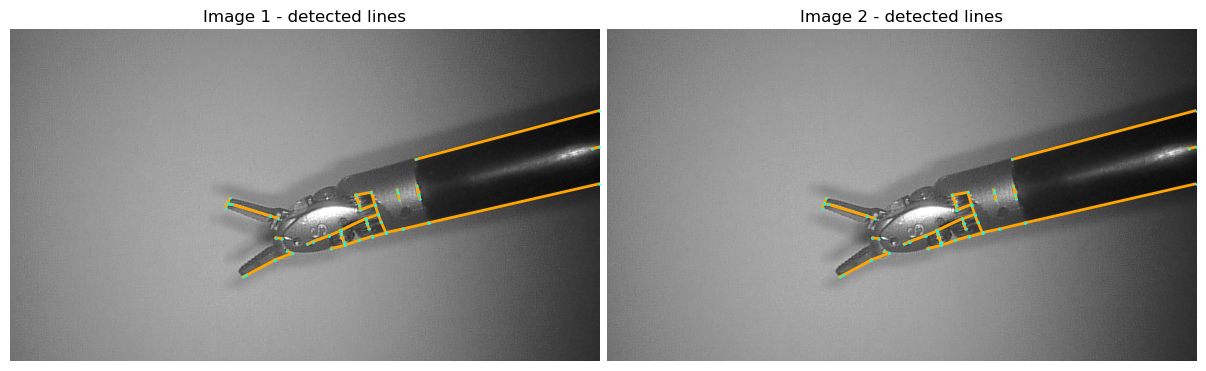

In [3]:
# left camera
crop_dims = (720, 1280)
chunksize = 1 # lines in csv to read at a time
count = 0
for data in pd.read_csv('../../journal_dataset/stereo-left-image.csv', chunksize = chunksize):
    for i in range((count * chunksize), len(data)):
        raw_string = data['data'][i]
        rgb = raw_string_to_rgb(raw_string = raw_string) # (1080, 1920, 3) ndarray uint8 [0, 255]
        print('rgb.shape: {}'.format(rgb.shape))
        print('rgb.dtype: {}'.format(rgb.dtype))
        # center crop
        rgb = center_crop(rgb, crop_dims)
        img = K.image_to_tensor(rgb).float() / 255.0 # [0, 1] torch.float32 [3, 1080, 1920]
        print('img.shape: {}'.format(img.shape))
        print('img.dtype: {}'.format(img.dtype))
        img = K.color.rgb_to_grayscale(img) # [0, 1] torch.float32 [1, 1080, 1920]
        print('img.shape: {}'.format(img.shape))
        print('img.dtype: {}'.format(img.dtype))
        imgs = torch.stack([img, img], )
        #imgs = torch.stack([img], )
        with torch.inference_mode():
            outputs = sold2(imgs)
        if (i >= 1):
            break
    if (count >= 1):
        break
    count += 1

# get line segments
line_seg1 = outputs["line_segments"][0]
line_seg2 = outputs["line_segments"][1]
desc1 = outputs["dense_desc"][0]
desc2 = outputs["dense_desc"][1]

# plot detected lines
imgs_to_plot = [K.tensor_to_image(img), K.tensor_to_image(img)]
#imgs_to_plot = [K.tensor_to_image(img)]
lines_to_plot = [line_seg1.numpy(), line_seg2.numpy()]
#lines_to_plot = [line_seg1.numpy()]

plot_images(imgs_to_plot, ["Image 1 - detected lines", "Image 2 - detected lines"])
#plot_images(imgs_to_plot, ["Image - detected lines"])
plot_lines(lines_to_plot, ps=3, lw=2, indices={0, 1})
#plot_lines(lines_to_plot, ps=3, lw=2, indices={0})

(h, w): (720, 1280)


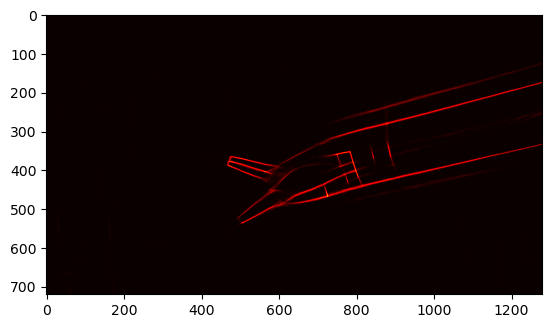

In [4]:
# extract reference line heatmap
line_heatmap = np.asarray(outputs['line_heatmap'][0]) # output has size crop_dims: (h, w)
print('(h, w): {}'.format(line_heatmap.shape))
plt.imshow(line_heatmap, cmap = 'hot')

(h, w): (720, 1280)


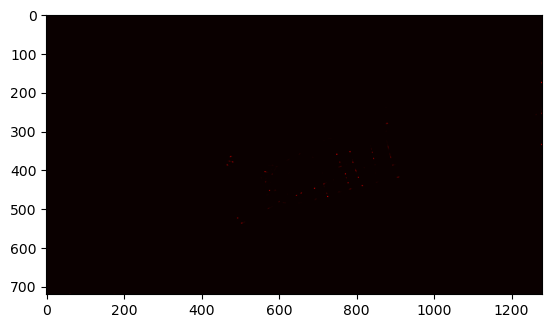

In [5]:
# extract end points
junction_heatmap = np.asarray(outputs['junction_heatmap'][0]) # output has size crop_dims: (h, w)
print('(h, w): {}'.format(junction_heatmap.shape))
plt.imshow(junction_heatmap, cmap = 'hot')

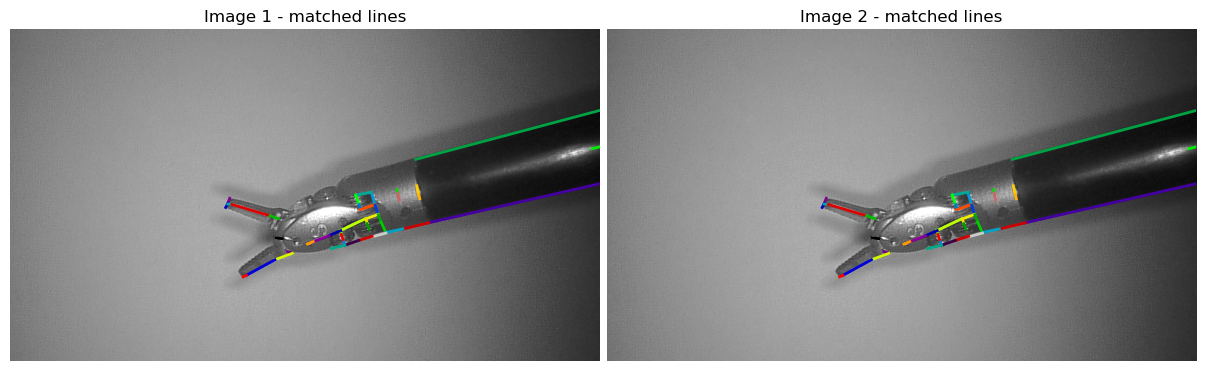

In [6]:
# line matching
with torch.inference_mode():
    matches = sold2.match(line_seg1, line_seg2, desc1[None], desc2[None])
valid_matches = matches != -1
match_indices = matches[valid_matches]

matched_lines1 = line_seg1[valid_matches]
matched_lines2 = line_seg2[match_indices]

# plot matched lines
imgs_to_plot = [K.tensor_to_image(img), K.tensor_to_image(img)]
plot_images(imgs_to_plot, ["Image 1 - matched lines", "Image 2 - matched lines"])
plot_color_line_matches([matched_lines1, matched_lines2], lw=2)

SOLD2 (Create reference image)

rgb.shape: (1080, 1920, 3)


/var/folders/gh/y3fztvpd2vlg_sy81hx7vt1m0000gn/T/ipykernel_7399/207968382.py:24: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  nparr = np.fromstring(byte_string, np.uint8)


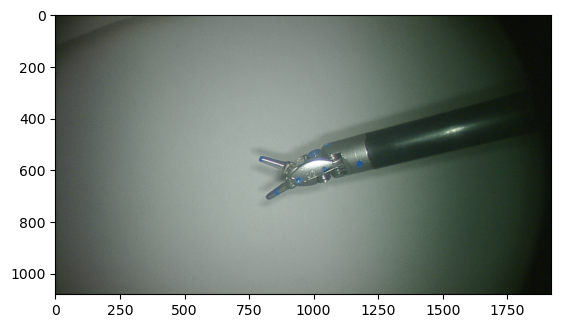

In [7]:
# read first image from left_cam
data = pd.read_csv('../../journal_dataset/stereo-left-image.csv', nrows = 1)
raw_string = data['data'][0]
rgb = raw_string_to_rgb(raw_string = raw_string) # 1080 x 1920 x 3 (RGB) uint8 ndarray [0, 255]
plt.imshow(rgb)

(crop_height, crop_width): [ 720 1280]
ref image type: <class 'numpy.ndarray'>
ref image dtype: uint8
(h, w): (720, 1280, 3)


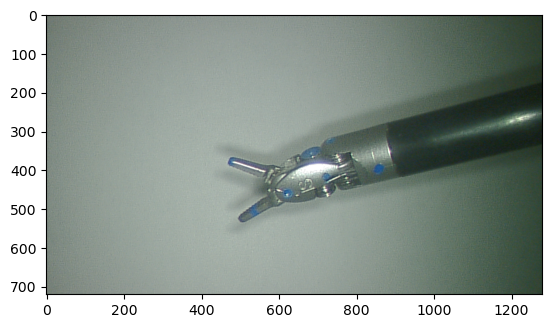

In [8]:
# crop and save reference image
crop_height = 720
crop_width = 1280
crop_dims = np.asarray([crop_height, crop_width])
np.save('crop_ref_dims.npy', crop_dims)
print('(crop_height, crop_width): {}'.format(crop_dims))

crop_rgb = center_crop(rgb, crop_dims)
plt.imshow(crop_rgb)
np.save('crop_ref_l.npy', crop_rgb) # (crop_dims, 3) RGB uint8
print('ref image type: {}'.format(type(crop_rgb)))
print('ref image dtype: {}'.format(crop_rgb.dtype))
print('(h, w): {}'.format(crop_rgb.shape))

/var/folders/gh/y3fztvpd2vlg_sy81hx7vt1m0000gn/T/ipykernel_7399/207968382.py:24: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  nparr = np.fromstring(byte_string, np.uint8)


rgb.shape: (1080, 1920, 3)


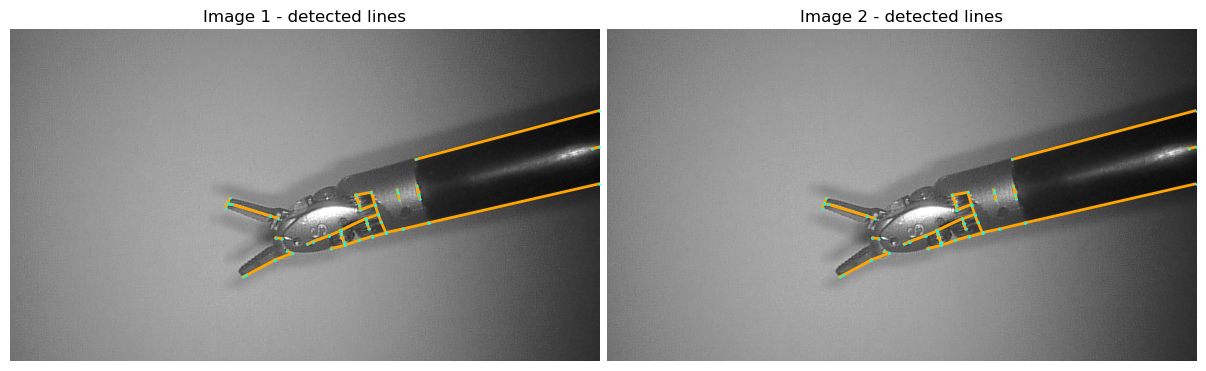

In [9]:
# use cropped image as ref image
ref_img = np.load('crop_ref_l.npy') # (crop_dims, 3) RGB uint8
ref_img = K.image_to_tensor(ref_img).float() / 255.0 # [0, 1] torch.Size([3, crop_dims]) torch.float32
ref_img = K.color.rgb_to_grayscale(ref_img) # [0, 1] torch.Size([1, crop_dims]) torch.float32

crop_ref_dims = np.load('crop_ref_dims.npy') # array([ crop_height, crop_width])
chunksize = 1 # lines in csv to read at a time
count = 0
for data in pd.read_csv('../../journal_dataset/stereo-left-image.csv', chunksize = chunksize):
    for i in range((count * chunksize), len(data)):
        raw_string = data['data'][i]
        rgb = raw_string_to_rgb(raw_string = raw_string) # 1080 x 1920 x 3 (RGB) uint8 ndarray [0 255]
        new_img = center_crop(rgb, crop_ref_dims) # crop_dims x 3 (RGB) uint8 ndarray [0 255]
        new_img = K.image_to_tensor(new_img).float() / 255.0  # [0, 1] [3, crop_dims] float32
        new_img = K.color.rgb_to_grayscale(new_img) # [0, 1] [1, crop_dims] float32
        imgs = torch.stack([ref_img, new_img], )
        with torch.inference_mode():
            outputs = sold2(imgs)
        if (i >= 1):
            break
    if (count >= 1):
        break
    count += 1

# get line segments
line_seg1 = outputs["line_segments"][0]
line_seg2 = outputs["line_segments"][1]
desc1 = outputs["dense_desc"][0]
desc2 = outputs["dense_desc"][1]

# plot detected lines
imgs_to_plot = [K.tensor_to_image(ref_img), K.tensor_to_image(new_img)]
lines_to_plot = [line_seg1.numpy(), line_seg2.numpy()]

plot_images(imgs_to_plot, ["Image 1 - detected lines", "Image 2 - detected lines"])
plot_lines(lines_to_plot, ps=3, lw=2, indices={0, 1})

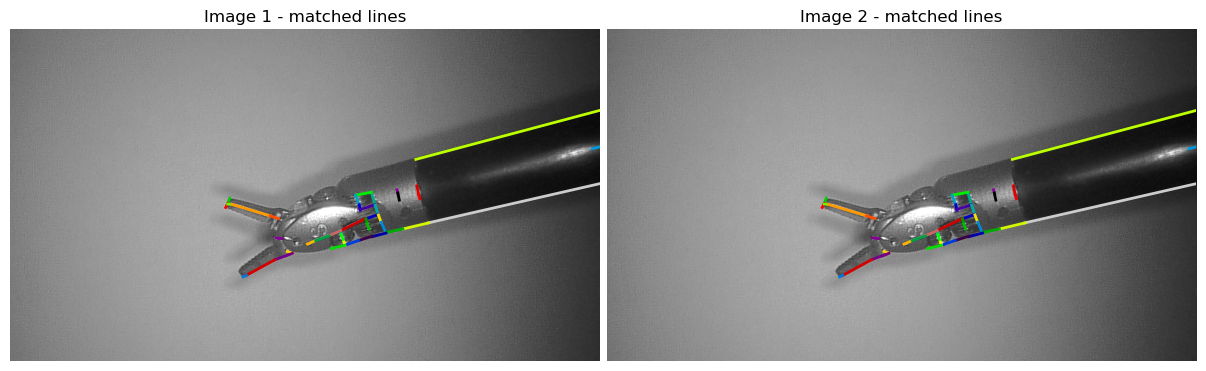

In [10]:
# line matching
with torch.inference_mode():
    matches = sold2.match(line_seg1, line_seg2, desc1[None], desc2[None])
valid_matches = matches != -1
match_indices = matches[valid_matches]

matched_lines1 = line_seg1[valid_matches]
matched_lines2 = line_seg2[match_indices]

# plot matched lines
imgs_to_plot = [K.tensor_to_image(img), K.tensor_to_image(img)]
plot_images(imgs_to_plot, ["Image 1 - matched lines", "Image 2 - matched lines"])
plot_color_line_matches([matched_lines1, matched_lines2], lw=2)

[2 0]


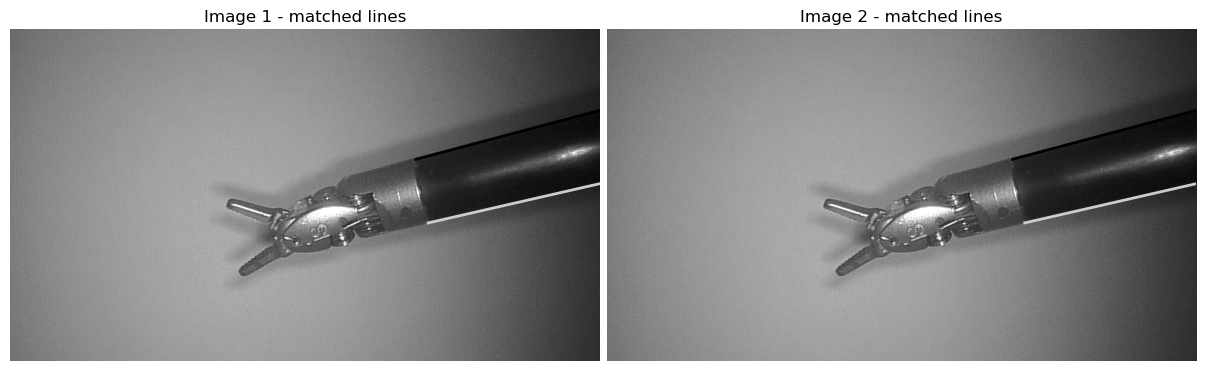

In [11]:
# pick only shaft lines in reference image by length (largest 2x lines)
reference_line_lengths = []
for i in range(matched_lines1.shape[0]):
    reference_line_lengths.append(np.linalg.norm(matched_lines1[i][0] - matched_lines1[i][1]))
reference_line_lengths = np.asarray(reference_line_lengths)
ind = np.argpartition(reference_line_lengths, -2)[-2:]
print(ind)

# plot matched shaft lines only
plot_images(imgs_to_plot, ["Image 1 - matched lines", "Image 2 - matched lines"])
selected_lines1 = matched_lines1[ind]
selected_lines2 = matched_lines2[ind]
plot_color_line_matches([selected_lines1, selected_lines2], lw=2)

# save reference line endpoints
np.save('crop_ref_lines_l.npy', np.asarray(selected_lines1))

RESUME HERE
- match ref image with new image
- get heatmap lines from new image
- get error from heatmap lines compared to projection

SOLD2 (Match ref image with new image)

/var/folders/gh/y3fztvpd2vlg_sy81hx7vt1m0000gn/T/ipykernel_7399/207968382.py:24: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  nparr = np.fromstring(byte_string, np.uint8)


rgb.shape: (1080, 1920, 3)


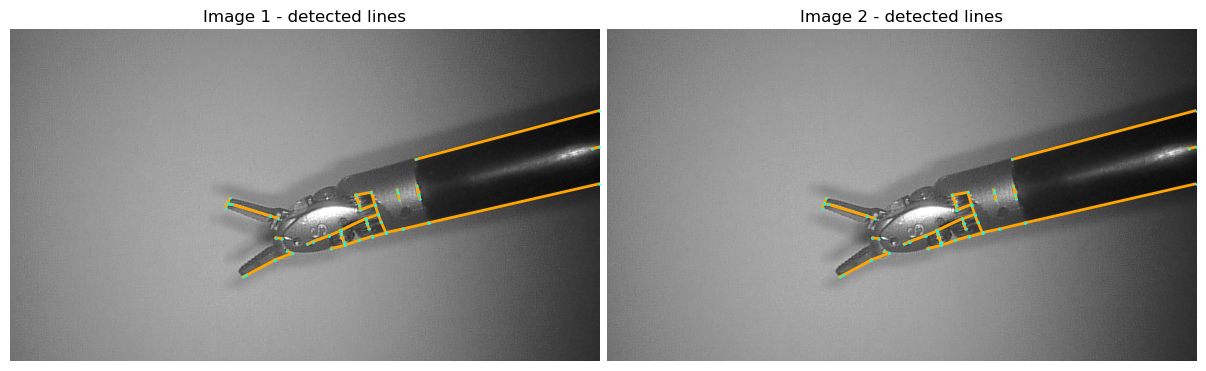

In [12]:
# match ref image with new image
ref_img = np.load('crop_ref_l.npy') # (crop_dims, 3) RGB uint8
ref_img = K.image_to_tensor(ref_img).float() / 255.0 # [0, 1] torch.Size([3, crop_dims]) torch.float32
ref_img = K.color.rgb_to_grayscale(ref_img) # [0, 1] torch.Size([1, crop_dims]) torch.float32

crop_ref_dims = np.load('crop_ref_dims.npy') # array([ crop_height, crop_width])
chunksize = 1 # lines in csv to read at a time
count = 0
for data in pd.read_csv('../../journal_dataset/stereo-left-image.csv', chunksize = chunksize):
    for i in range((count * chunksize), len(data)):
        raw_string = data['data'][i]
        rgb = raw_string_to_rgb(raw_string = raw_string) # 1080 x 1920 x 3 (RGB) uint8 ndarray [0 255]
        new_img = center_crop(rgb, crop_ref_dims) # crop_dims x 3 (RGB) uint8 ndarray [0 255]
        new_img = K.image_to_tensor(new_img).float() / 255.0  # [0, 1] [3, crop_dims] float32
        new_img = K.color.rgb_to_grayscale(new_img) # [0, 1] [1, crop_dims] float32
        imgs = torch.stack([ref_img, new_img], )
        with torch.inference_mode():
            outputs = sold2(imgs)
        if (i >= 1):
            break
    if (count >= 1):
        break
    count += 1

# get line segments
line_seg1 = outputs["line_segments"][0]
line_seg2 = outputs["line_segments"][1]
desc1 = outputs["dense_desc"][0]
desc2 = outputs["dense_desc"][1]

# plot detected lines
imgs_to_plot = [K.tensor_to_image(ref_img), K.tensor_to_image(new_img)]
lines_to_plot = [line_seg1.numpy(), line_seg2.numpy()]

plot_images(imgs_to_plot, ["Image 1 - detected lines", "Image 2 - detected lines"])
plot_lines(lines_to_plot, ps=3, lw=2, indices={0, 1})

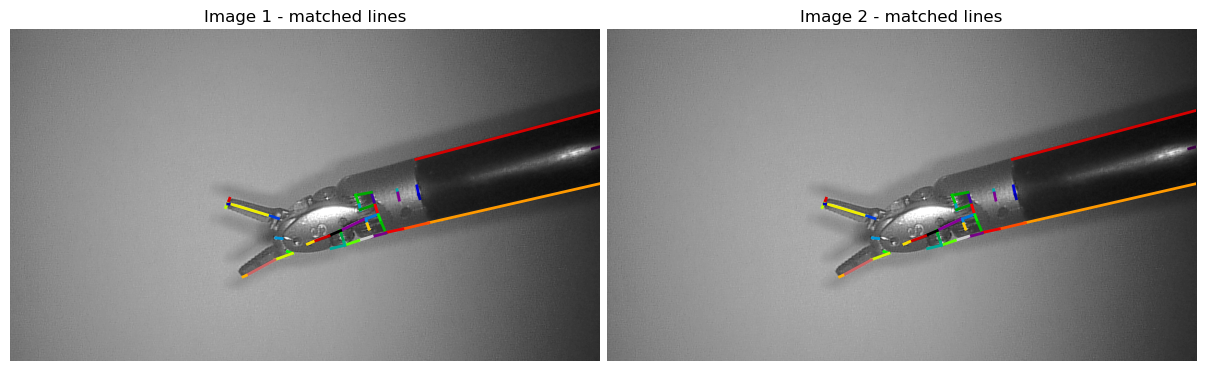

In [13]:
# line matching between reference and new image
with torch.inference_mode():
    matches = sold2.match(line_seg1, line_seg2, desc1[None], desc2[None])
valid_matches = matches != -1
match_indices = matches[valid_matches]

matched_lines1 = line_seg1[valid_matches]
matched_lines2 = line_seg2[match_indices]

# plot matched lines
imgs_to_plot = [K.tensor_to_image(img), K.tensor_to_image(img)]
plot_images(imgs_to_plot, ["Image 1 - matched lines", "Image 2 - matched lines"])
plot_color_line_matches([matched_lines1, matched_lines2], lw=2)

In [15]:
# load ref lines and find identical lines in ref_img lines (matched_lines1)
ref_lines = torch.as_tensor(np.load('crop_ref_lines_l.npy')) # torch.Size([2, 2, 2])
dist = distance_matrix(ref_lines, matched_lines1)


ValueError: too many values to unpack (expected 2)

In [36]:
sorted_indices = ref_lines[:, :, 0].sort()[1]
ref_lines_sorted = ref_lines[[[0], [1]], sorted_indices]
ref_lines_sorted

tensor([[[2, 1],
         [4, 3]],

        [[2, 8],
         [5, 6]]])

In [35]:
ref_lines = torch.as_tensor(np.asarray([[[4, 3], [2, 1]], [[5, 6], [2, 8]]]))

In [23]:
ref_lines.flatten().unsqueeze(0)

tensor([[ 334.7500, 1278.7500,  419.7500,  907.2500,  175.7500, 1278.7500,
          281.7500,  880.7500]])

In [ ]:

ind = np.argmin(dist, axis = 1)
selected_lines1 = matched_lines1[ind]
# then get matching lines in matched_lines2
selected_lines2 = matched_lines2[ind] # torch.Size([2, 2, 2])

SOLD2 (Augmentation)

In [19]:
'''
# [0, 1] normalize line heatmap for augmentation
line_heatmap = torch.as_tensor(line_heatmap.reshape((-1, 1080, 1920))) # torch.float32 [1, 1080, 1920]
line_heatmap_min = torch.min(line_heatmap)
line_heatmap_max = torch.max(line_heatmap)
line_heatmap = line_heatmap.view(line_heatmap.size(0), -1)
line_heatmap -= line_heatmap_min
line_heatmap /= line_heatmap_max
line_heatmap = line_heatmap.view(1, 1080, -1) # [0, 1] torch.float32 [1, 1080, 1920]
print('line_heatmap.shape: {}'.format(line_heatmap.shape))
print('line_heatmap.dtype: {}'.format(line_heatmap.dtype))
# line_heatmap = line_heatmap.float() / 255.0
# plt.imshow(K.tensor_to_image(line_heatmap), 'gray')
#line_heatmap = cv2.cvtColor(line_heatmap, cv2.COLOR_GRAY2RGB) # output is (1080, 1920, 3)
#line_heatmap = K.image_to_tensor(line_heatmap).float() / 255.0
#line_heatmap = K.color.rgb_to_grayscale(line_heatmap)
# plt.imshow(K.tensor_to_image(line_heatmap), 'gray')
'''

'''
# check that the min/max pixels are correctly aligned post-reshape
print(torch.min(img))
print(torch.max(img))
line_heatmap_min = torch.min(line_heatmap)
line_heatmap_max = torch.max(line_heatmap)
print(line_heatmap_min)
print(line_heatmap_max)
indices = (line_heatmap==line_heatmap_max).nonzero()[0]
print(indices)
print(line_heatmap[indices[0], indices[1], indices[2]])
indices = (line_heatmap==line_heatmap_min).nonzero()[0]
print(indices)
print(line_heatmap[indices[0], indices[1], indices[2]])
line_heatmap = line_heatmap.view(line_heatmap.size(0), -1)
line_heatmap -= line_heatmap_min
line_heatmap /= line_heatmap_max
line_heatmap = line_heatmap.view(1, 1080, -1)
print(line_heatmap.shape)
print((line_heatmap==torch.max(line_heatmap)).nonzero())
print((line_heatmap==torch.min(line_heatmap)).nonzero())
'''

'''
# show reference image
plt.imshow(K.tensor_to_image(img), 'gray')
'''

'''
# augment reference image with normalized line heatmap and save
augmented_ref = img + line_heatmap # torch.Size([1, 1080, 1920]) float32

# ensure augmented_ref is scaled from 0 to 1
augmented_ref_min = torch.min(augmented_ref)
augmented_ref_max = torch.max(augmented_ref)
augmented_ref = augmented_ref.view(augmented_ref.size(0), -1)
augmented_ref -= augmented_ref_min
augmented_ref /= augmented_ref_max
augmented_ref = augmented_ref.view(1, 1080, -1) # torch.Size([1, 1080, 1920]) float32 [0, 1]
print(augmented_ref.shape)
print(augmented_ref.dtype)
print(augmented_ref.min())
print(augmented_ref.max())
plt.imshow(K.tensor_to_image(augmented_ref), 'gray')
np.save('augmented_ref_l.npy', augmented_ref) # [0, 1] float32 torch.Size([1, 1080, 1920])
# plt.imshow(K.tensor_to_image(img), 'gray')
# line_heatmap_rgb = cv2.cvtColor(line_heatmap, cv2.COLOR_GRAY2RGB) # output is (1080, 1920, 3)
'''
'''
# now do line detection using sold2 augmented ref with new image
augmented_ref = torch.as_tensor(np.load('augmented_ref_l.npy')) # [0, 1] normalized tensor [1, 1080, 1920] float32

chunksize = 1 # lines in csv to read at a time
count = 0
for data in pd.read_csv('../../journal_dataset/stereo-left-image.csv', chunksize = chunksize):
    for i in range((count * chunksize), len(data)):
        raw_string = data['data'][i]
        rgb = raw_string_to_rgb(raw_string = raw_string) # (1080, 1920, 3) ndarray uint8 [0, 255]
        print('rgb.shape: {}'.format(rgb.shape))
        print('rgb.dtype: {}'.format(rgb.dtype))
        img = K.image_to_tensor(rgb).float() / 255.0 # [0, 1] torch.float32 [3, 1080, 1920]
        print('img.shape: {}'.format(img.shape))
        print('img.dtype: {}'.format(img.dtype))
        img = K.color.rgb_to_grayscale(img) # [0, 1] torch.float32 [1, 1080, 1920]
        print('img.shape: {}'.format(img.shape))
        print('img.dtype: {}'.format(img.dtype))
        imgs = torch.stack([img, img], )

        with torch.inference_mode():
            outputs = sold2(imgs)
        
        # extract reference line heatmap
        line_heatmap = np.asarray(outputs['line_heatmap'][0]) # output is (1080, 1920)

        # [0, 1] normalize
        line_heatmap = torch.as_tensor(line_heatmap.reshape((-1, 1080, 1920))) # torch.float32 [1, 1080, 1920]
        line_heatmap_min = torch.min(line_heatmap)
        line_heatmap_max = torch.max(line_heatmap)
        line_heatmap = line_heatmap.view(line_heatmap.size(0), -1)
        line_heatmap -= line_heatmap_min
        line_heatmap /= line_heatmap_max
        line_heatmap = line_heatmap.view(1, 1080, -1) # [0, 1] torch.float32 [1, 1080, 1920]

        # augment image with line heatmap 
        augmented_img = img + line_heatmap # torch.Size([1, 1080, 1920]) float32

        # ensure augmented_img is scaled from 0 to 1
        augmented_img_min = torch.min(augmented_img)
        augmented_img_max = torch.max(augmented_img)
        augmented_img = augmented_img.view(augmented_img.size(0), -1)
        augmented_img -= augmented_img_min
        augmented_img /= augmented_img_max
        augmented_img = augmented_img.view(1, 1080, -1) # torch.Size([1, 1080, 1920]) float32 [0, 1]

        # run inference on augmented ref and augmented new image       
        imgs = torch.stack([augmented_ref, augmented_img], )
        with torch.inference_mode():
            outputs = sold2(imgs)

        if (i >= 1):
            break
    if (count >= 1):
        break
    count += 1

# get line segments
line_seg1 = outputs["line_segments"][0]
line_seg2 = outputs["line_segments"][1]
desc1 = outputs["dense_desc"][0]
desc2 = outputs["dense_desc"][1]

# plot detected lines
imgs_to_plot = [K.tensor_to_image(augmented_ref), K.tensor_to_image(augmented_img)]
lines_to_plot = [line_seg1.numpy(), line_seg2.numpy()]

plot_images(imgs_to_plot, ["Image 1 - detected lines", "Image 2 - detected lines"])
plot_lines(lines_to_plot, ps=3, lw=2, indices={0, 1})
'''

'''
# now do line matching between augmented image and new image
with torch.inference_mode():
    matches = sold2.match(line_seg1, line_seg2, desc1[None], desc2[None])
valid_matches = matches != -1
match_indices = matches[valid_matches]

matched_lines1 = line_seg1[valid_matches]
matched_lines2 = line_seg2[match_indices]

# plot matched lines
plot_images(imgs_to_plot, ["Image 1 - matched lines", "Image 2 - matched lines"])
plot_color_line_matches([matched_lines1, matched_lines2], lw=2)
'''

line_heatmap.shape: torch.Size([1, 1080, 1920])
line_heatmap.dtype: torch.float32


Canny

Left Camera

rgb.shape: (1080, 1920, 3)


/var/folders/gh/y3fztvpd2vlg_sy81hx7vt1m0000gn/T/ipykernel_42807/3708385016.py:24: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  nparr = np.fromstring(byte_string, np.uint8)


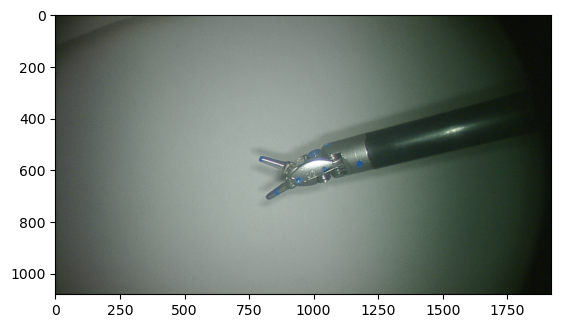

In [30]:
# read first image from left_cam
data = pd.read_csv('../../journal_dataset/stereo-left-image.csv', nrows = 1)
raw_string = data['data'][0]
left_cam_reference_rgb = raw_string_to_rgb(raw_string = raw_string) # 1080 x 1920 x 3 (RGB) uint8 ndarray [0, 255]
plt.imshow(left_cam_reference_rgb)

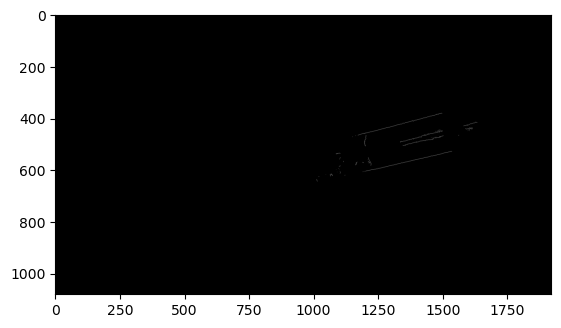

In [31]:
left_cam_reference_canny = canny_preprocess(left_cam_reference_rgb) # 1080 x 1920 x 3 (RGB) uint8 ndarray [0 255]
plt.imshow(left_cam_reference_canny)

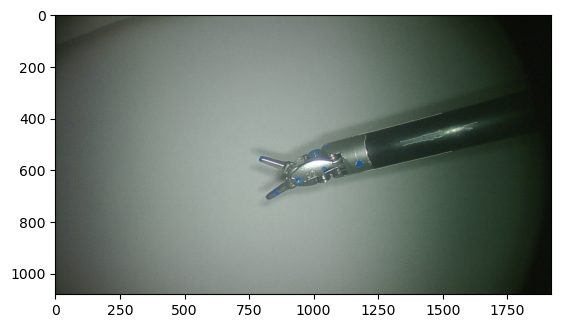

In [32]:
# augment original camera image with canny edges
assert(left_cam_reference_rgb.min() >= 0)
assert(left_cam_reference_rgb.max() <= 255)
assert(left_cam_reference_canny.min() >= 0)
assert(left_cam_reference_canny.max() <= 255)
temp = np.zeros_like(left_cam_reference_rgb, dtype=np.uint16)
assert(temp.shape == left_cam_reference_rgb.shape == left_cam_reference_canny.shape)
temp += left_cam_reference_rgb
temp += left_cam_reference_canny
temp[temp > 255] = 255
assert(temp.min() >= 0)
assert(temp.max() <= 255)
augmented_img = np.array(temp, dtype=np.uint8) # (1080, 1920, 3) RGB uint8
assert(augmented_img.min() >= 0)
assert(augmented_img.max() <= 255)
assert(augmented_img.shape == left_cam_reference_rgb.shape == left_cam_reference_canny.shape)
plt.imshow(augmented_img)
np.save('canny_augmented_ref_l.npy', augmented_img) # (1080, 1920, 3) RGB uint8

/var/folders/gh/y3fztvpd2vlg_sy81hx7vt1m0000gn/T/ipykernel_42807/3708385016.py:24: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  nparr = np.fromstring(byte_string, np.uint8)


rgb.shape: (1080, 1920, 3)


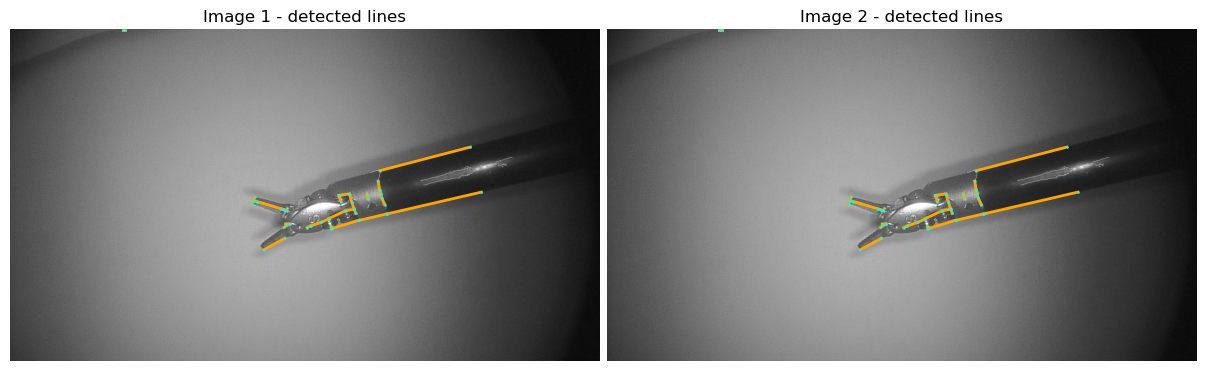

In [33]:
# use canny augmented ref as ref image
augmented_ref = np.load('canny_augmented_ref_l.npy') # (1080, 1920, 3) RGB uint8
augmented_ref = K.image_to_tensor(augmented_ref).float() / 255.0 # [0, 1] torch.Size([3, 1080, 1920]) torch.float32
augmented_ref = K.color.rgb_to_grayscale(augmented_ref) # [0, 1] torch.Size([1, 1080, 1920]) torch.float32

chunksize = 1 # lines in csv to read at a time
count = 0
for data in pd.read_csv('../../journal_dataset/stereo-left-image.csv', chunksize = chunksize):
    for i in range((count * chunksize), len(data)):
        raw_string = data['data'][i]
        rgb = raw_string_to_rgb(raw_string = raw_string) # 1080 x 1920 x 3 (RGB) uint8 ndarray [0 255]
        canny = canny_preprocess(rgb) # 1080 x 1920 x 3 (RGB) uint8 ndarray [0 255]
        temp = np.zeros_like(rgb, dtype=np.uint16)
        assert(temp.shape == rgb.shape == canny.shape)
        temp += rgb
        temp += canny
        temp[temp > 255] = 255
        augmented_img = np.array(temp, dtype=np.uint8) # (1080, 1920, 3) RGB uint8
        assert(augmented_img.min() >= 0)
        assert(augmented_img.max() <= 255)
        augmented_img = K.image_to_tensor(augmented_img).float() / 255.0  # [0, 1] [3, 1080, 1920] float32
        assert(augmented_img.shape == (3, 1080, 1920))
        augmented_img = K.color.rgb_to_grayscale(augmented_img) # [0, 1] [1, 1080, 1920] float32
        assert(augmented_img.min() >= 0)
        assert(augmented_img.max() <= 1)
        assert(augmented_ref.min() >= 0)
        assert(augmented_ref.max() <= 1)
        assert(augmented_img.shape == augmented_ref.shape == (1, 1080, 1920))
        imgs = torch.stack([augmented_ref, augmented_img], )
        with torch.inference_mode():
            outputs = sold2(imgs)
        if (i >= 1):
            break
    if (count >= 1):
        break
    count += 1

# get line segments
line_seg1 = outputs["line_segments"][0]
line_seg2 = outputs["line_segments"][1]
desc1 = outputs["dense_desc"][0]
desc2 = outputs["dense_desc"][1]

# plot detected lines
imgs_to_plot = [K.tensor_to_image(augmented_ref), K.tensor_to_image(augmented_img)]
lines_to_plot = [line_seg1.numpy(), line_seg2.numpy()]

plot_images(imgs_to_plot, ["Image 1 - detected lines", "Image 2 - detected lines"])
plot_lines(lines_to_plot, ps=3, lw=2, indices={0, 1})

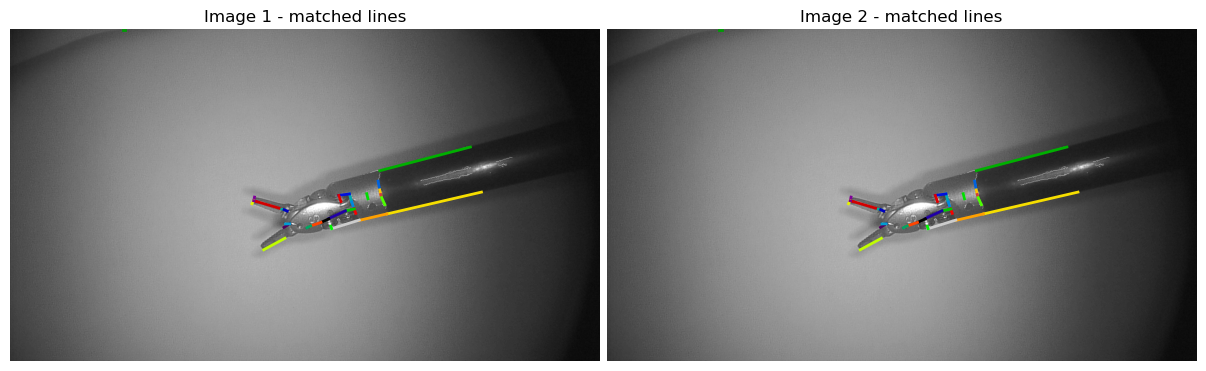

In [15]:
# line matching
with torch.inference_mode():
    matches = sold2.match(line_seg1, line_seg2, desc1[None], desc2[None])
valid_matches = matches != -1
match_indices = matches[valid_matches]

matched_lines1 = line_seg1[valid_matches]
matched_lines2 = line_seg2[match_indices]

# plot matched lines
plot_images(imgs_to_plot, ["Image 1 - matched lines", "Image 2 - matched lines"])
plot_color_line_matches([matched_lines1, matched_lines2], lw=2)

In [16]:
# pick only shaft lines
reference_line_lengths = []
for i in range(matched_lines1.shape[0]):
    reference_line_lengths.append(np.linalg.norm(matched_lines1[i][0] - matched_lines1[i][1]))
reference_line_lengths = np.asarray(reference_line_lengths)
ind = np.argpartition(reference_line_lengths, -2)[-2:]
print(ind)

[1 4]


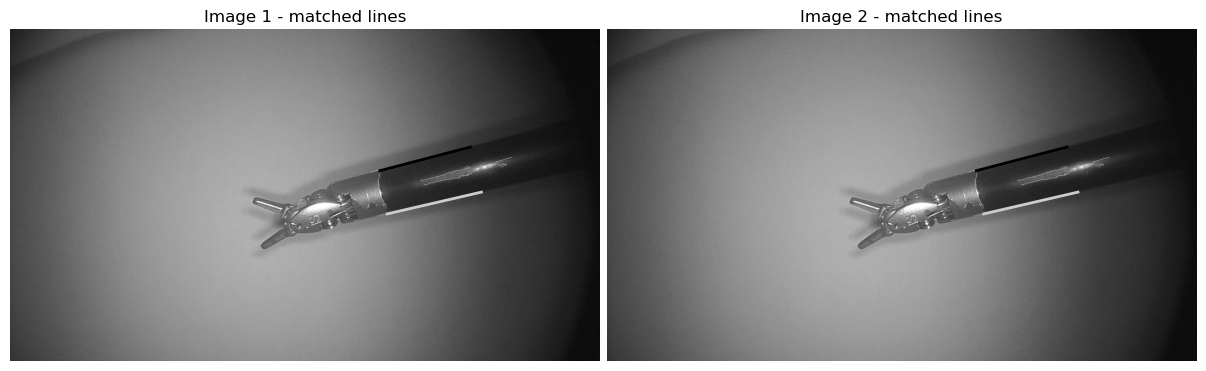

In [17]:
# plot matched shaft lines only
plot_images(imgs_to_plot, ["Image 1 - matched lines", "Image 2 - matched lines"])
selected_lines1 = matched_lines1[ind]
selected_lines2 = matched_lines2[ind]
plot_color_line_matches([selected_lines1, selected_lines2], lw=2)

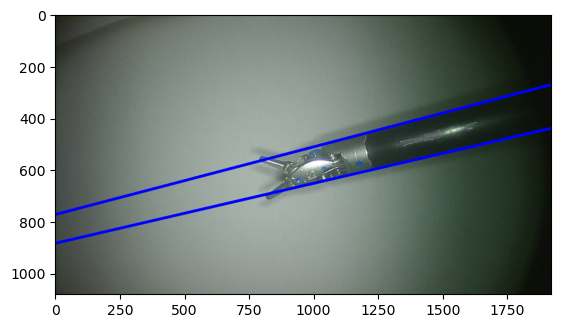

In [18]:
# save reference shaft lines in y = mx + b format
ref_lines = []
for i in range(selected_lines1.shape[0]):
    x1, y1, x2, y2 = selected_lines1[i][0][1], selected_lines1[i][0][0], selected_lines1[i][1][1], selected_lines1[i][1][0]
    m = (y2 - y1) / (x2 - x1)
    b = m * x1 - y1
    b *= -1
    ref_lines.append([float(m), float(b)])
np.save('ref_lines.npy', np.asarray(ref_lines)) # 2x2 np array [[m, b], [m, b]]

# confirm reference lines are accurate
ref_lines = np.load('ref_lines.npy')
image_height = 1080
image_width = 1920
image = cv2.imread('left_cam_reference_canny.png') # loads in BGR

for line in ref_lines:
    m = line[0]
    b = line[1]
    x0 = int(0)
    y0 = int(m * x0 + b)
    x1 = int(image_width)
    y1 = int(m * x1 + b)
    image = cv2.line(image, (x0, y0), (x1, y1), (255, 0, 0), 10)

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    

/tmp/ipykernel_5310/3708385016.py:24: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  nparr = np.fromstring(byte_string, np.uint8)


rgb.shape: (1080, 1920, 3)


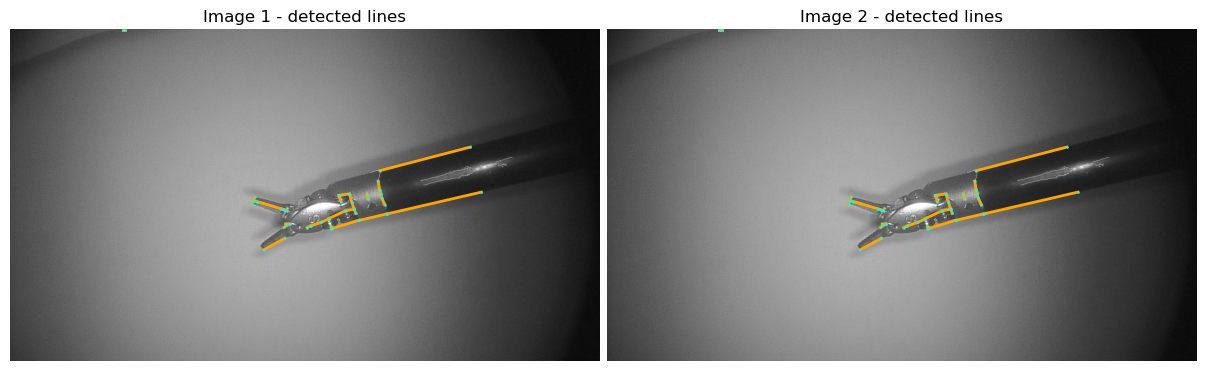

In [19]:
# process new images using canny augmented ref as ref image
augmented_ref = np.load('canny_augmented_ref_l.npy') # (1080, 1920, 3) RGB uint8
augmented_ref = K.image_to_tensor(augmented_ref).float() / 255.0 # [0, 1] torch.Size([3, 1080, 1920]) torch.float32
augmented_ref = K.color.rgb_to_grayscale(augmented_ref) # [0, 1] torch.Size([1, 1080, 1920]) torch.float32

chunksize = 1 # lines in csv to read at a time
count = 0
for data in pd.read_csv('../../journal_dataset/stereo-left-image.csv', chunksize = chunksize):
    for i in range((count * chunksize), len(data)):
        raw_string = data['data'][i]
        rgb = raw_string_to_rgb(raw_string = raw_string) # 1080 x 1920 x 3 (RGB) uint8 ndarray [0 255]
        canny = canny_preprocess(rgb) # 1080 x 1920 x 3 (RGB) uint8 ndarray [0 255]
        temp = np.zeros_like(rgb, dtype=np.uint16)
        assert(temp.shape == rgb.shape == canny.shape)
        temp += rgb
        temp += canny
        temp[temp > 255] = 255
        augmented_img = np.array(temp, dtype=np.uint8) # (1080, 1920, 3) RGB uint8
        assert(augmented_img.min() >= 0)
        assert(augmented_img.max() <= 255)
        augmented_img = K.image_to_tensor(augmented_img).float() / 255.0  # [0, 1] [3, 1080, 1920] float32
        assert(augmented_img.shape == (3, 1080, 1920))
        augmented_img = K.color.rgb_to_grayscale(augmented_img) # [0, 1] [1, 1080, 1920] float32
        assert(augmented_img.min() >= 0)
        assert(augmented_img.max() <= 1)
        assert(augmented_ref.min() >= 0)
        assert(augmented_ref.max() <= 1)
        assert(augmented_img.shape == augmented_ref.shape == (1, 1080, 1920))
        imgs = torch.stack([augmented_ref, augmented_img], )
        with torch.inference_mode():
            outputs = sold2(imgs)
        if (i >= 1):
            break
    if (count >= 1):
        break
    count += 1

# get line segments
line_seg1 = outputs["line_segments"][0]
line_seg2 = outputs["line_segments"][1]
desc1 = outputs["dense_desc"][0]
desc2 = outputs["dense_desc"][1]

# plot detected lines
imgs_to_plot = [K.tensor_to_image(augmented_ref), K.tensor_to_image(augmented_img)]
lines_to_plot = [line_seg1.numpy(), line_seg2.numpy()]

plot_images(imgs_to_plot, ["Image 1 - detected lines", "Image 2 - detected lines"])
plot_lines(lines_to_plot, ps=3, lw=2, indices={0, 1})

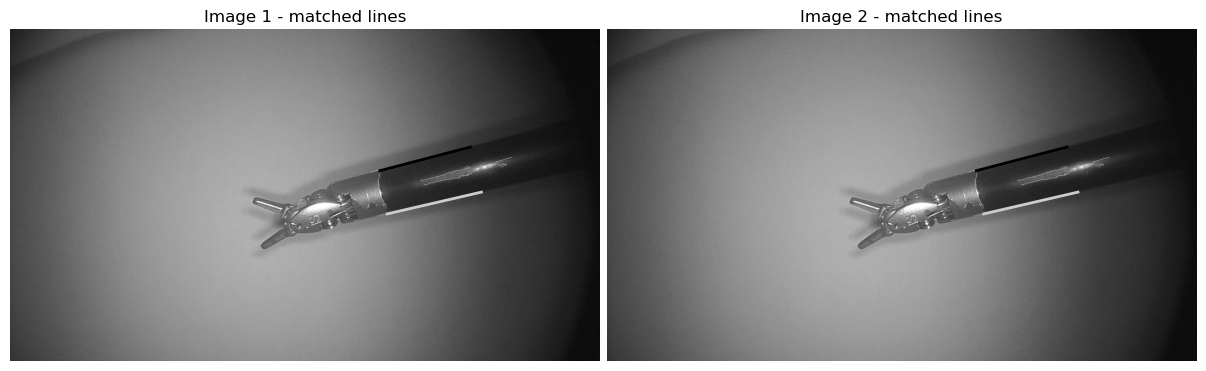

In [20]:
# line matching
with torch.inference_mode():
    matches = sold2.match(line_seg1, line_seg2, desc1[None], desc2[None])
valid_matches = matches != -1
match_indices = matches[valid_matches]

matched_lines1 = line_seg1[valid_matches] # torch.Size([30, 2, 2])
matched_lines2 = line_seg2[match_indices]

# load ref lines and find identical lines in matched_lines1
# then find matching lines in matched_lines2
ref_lines = np.load('ref_lines.npy') # 2x2 numpy array [[m, b], [m, b]]
matched_lines1_ymxb = []
for i in range(matched_lines1.shape[0]):
    x1, y1, x2, y2 = matched_lines1[i][0][1], matched_lines1[i][0][0], matched_lines1[i][1][1], matched_lines1[i][1][0]
    m = (y2 - y1) / (x2 - x1)
    b = m * x1 - y1
    b *= -1
    matched_lines1_ymxb.append([float(m), float(b)])
matched_lines1_ymxb = np.asarray(matched_lines1_ymxb)
dist = distance_matrix(ref_lines, matched_lines1_ymxb)
ind = np.argmin(dist, axis = 1)
selected_lines1 = matched_lines1[ind]
selected_lines2 = matched_lines2[ind] # torch.Size([2, 2, 2])

# plot matched lines
plot_images(imgs_to_plot, ["Image 1 - matched lines", "Image 2 - matched lines"])
plot_color_line_matches([selected_lines1, selected_lines2], lw=2)

Measuring error

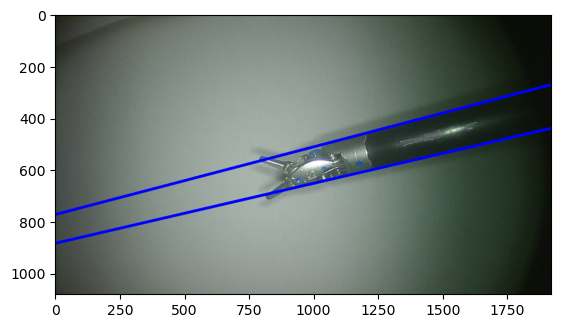

In [21]:
# convert selected_lines2 from new image to y = mx + b
selected_lines2_ymxb = []
for i in range(selected_lines2.shape[0]):
    x1, y1, x2, y2 = selected_lines2[i][0][1], selected_lines2[i][0][0], selected_lines2[i][1][1], selected_lines2[i][1][0]
    m = (y2 - y1) / (x2 - x1)
    b = m * x1 - y1
    b *= -1
    selected_lines2_ymxb.append([float(m), float(b)])

# confirm selected lines are accurate
image_height = 1080
image_width = 1920
image = cv2.imread('left_cam_reference_canny.png') # loads in BGR

for line in selected_lines2_ymxb:
    m = line[0]
    b = line[1]
    x0 = int(0)
    y0 = int(m * x0 + b)
    x1 = int(image_width)
    y1 = int(m * x1 + b)
    image = cv2.line(image, (x0, y0), (x1, y1), (255, 0, 0), 10)

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

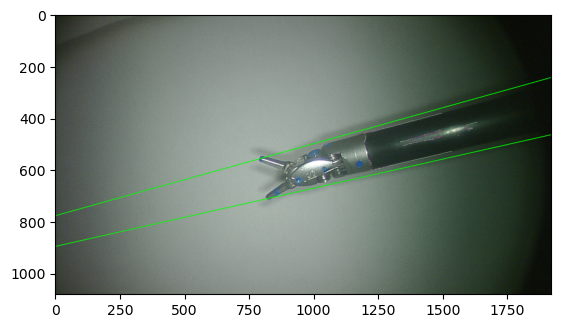

In [22]:
# simulate projected lines from FK
image = cv2.imread('left_cam_reference_canny.png') # loads in BGR
proj_lines = np.asarray([[750, 1.3], [875, 1.35]])
proj_lines_ymxb = []
for proj_line in proj_lines:
    rho = proj_line[0]
    theta = proj_line[1]
    a = math.cos(theta)
    b = math.sin(theta)
    x0 = a * rho
    y0 = b * rho
    pt1 = (int(x0 + 2000*(b)), int(y0 + 2000*(-a)))
    pt2 = (int(x0 - 2000*(b)), int(y0 - 2000*(-a)))
    image = cv2.line(image, pt1, pt2, (0, 255, 0), 2)
    x1, y1, x2, y2 = pt1[0], pt1[1], pt2[0], pt2[1]
    m = (y2 - y1) / (x2 - x1)
    b = m * x1 - y1
    b *= -1
    proj_lines_ymxb.append([m, b])
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

In [23]:
proj_lines_ymxb = np.asarray(proj_lines_ymxb)
selected_lines2_ymxb = np.asarray(selected_lines2_ymxb)
dist = distance_matrix(proj_lines_ymxb, selected_lines2_ymxb)
print(dist)
ind = np.argmin(dist, axis = 1)
print(ind.shape[0])
line_pairs_ymxb = []
line_pairs_pts = []
for i in range(ind.shape[0]):
    line_pairs_ymxb.append([proj_lines_ymxb[i, :], selected_lines2_ymxb[ind[i], :]])
    proj_line_m, proj_line_b = proj_lines_ymxb[i, 0], proj_lines_ymxb[i, 1]
    selected_line_m, selected_line_b = selected_lines2_ymxb[ind[i], 0], selected_lines2_ymxb[ind[i], 1]
    line_pairs_pts.append([[proj_line_m * x + proj_line_b for x in range(0, image_width)], [selected_line_m * x + selected_line_b for x in range(0, image_width)]])
line_pairs_pts = np.asarray(line_pairs_pts)

[[  3.73093026 106.76215915]
 [122.15495798  11.6619125 ]]
2


In [92]:
errors = []
vars = []
for i in range(line_pairs_pts.shape[0]):
    proj_pts = line_pairs_pts[i, 0, :]
    selected_pts = line_pairs_pts[i, 1, :]
    error = proj_pts - selected_pts
    print(error.shape)
    var = ((error- np.mean(error))**2).mean()
    print(var.shape)
    errors.append(error)
    vars.append(var)

errors = np.asarray(errors)
vars = np.asarray(vars)
cov = np.cov(errors[0, :], errors[1, :])[0, 1]
var = vars.sum() + 2 * cov
print(errors.shape)
print(vars)
print(cov)
print(var)


(1920,)
()
(1920,)
()
(2, 1920)
[85.55958069 14.08028603]
-34.72692398179153
30.18601875359633


SCRATCH

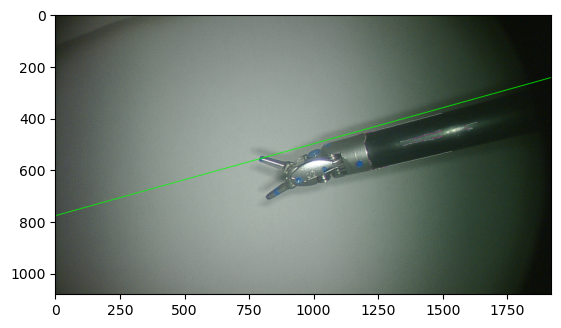

In [33]:
image = cv2.imread('left_cam_reference_canny.png') # loads in BGR
rho = 750
theta = 1.3
a = math.cos(theta)
b = math.sin(theta)
x0 = a * rho
y0 = b * rho
pt1 = (int(x0 + 2000*(-b)), int(y0 + 2000*(a)))
pt2 = (int(x0 - 2000*(-b)), int(y0 - 2000*(a)))
img = cv2.line(image, pt1, pt2, (0, 255, 0), 2)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

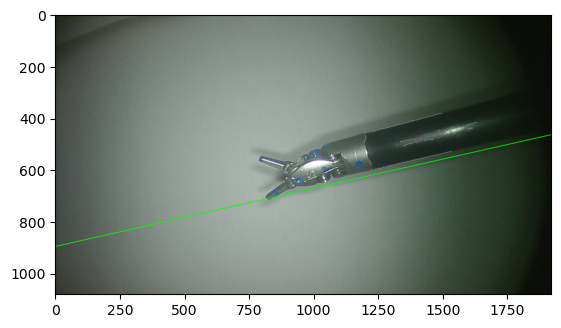

In [40]:
image = cv2.imread('left_cam_reference_canny.png') # loads in BGR
rho = 875
theta = 1.35
a = math.cos(theta)
b = math.sin(theta)
x0 = a * rho
y0 = b * rho
pt1 = (int(x0 + 2000*(-b)), int(y0 + 2000*(a)))
pt2 = (int(x0 - 2000*(-b)), int(y0 - 2000*(a)))
img = cv2.line(image, pt1, pt2, (0, 255, 0), 2)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

In [5]:
# read images from csv without saving to PIL saved PNG
# check for equality
# read first image from left_cam 
data = pd.read_csv('../../journal_dataset/stereo-left-image.csv', nrows = 1)
raw_string = data['data'][0]
left_cam_reference_rgb = raw_string_to_rgb(raw_string = raw_string)
left_cam_reference_rgb = K.image_to_tensor(left_cam_reference_rgb).float() / 255.0 # direct to RGB tensor (kornia_load_img converts from BGR to RGB first because read-in saved image is stored BGR)
assert(np.array_equal(left_cam_reference_rgb, torch_left_ref))
left_cam_reference_gray = K.color.rgb_to_grayscale(left_cam_reference_rgb)
assert(np.array_equal(left_cam_reference_gray, torch_left_ref_gray))

left_cam_reference_canny = raw_string_to_rgb(raw_string = raw_string)
left_cam_reference_canny = canny_preprocess(left_cam_reference_canny)
left_cam_reference_canny = K.image_to_tensor(left_cam_reference_canny).float() / 255.0 # direct to RGB tensor (kornia_load_img converts from BGR to RGB first because read-in saved image is stored BGR)
assert(np.array_equal(left_cam_reference_canny, torch_left_ref_canny))
left_cam_reference_gray_canny = K.color.rgb_to_grayscale(left_cam_reference_canny)
assert(np.array_equal(left_cam_reference_gray_canny, torch_left_ref_gray_canny))

rgb.shape: (1080, 1920, 3)
rgb.shape: (1080, 1920, 3)


/var/folders/gh/y3fztvpd2vlg_sy81hx7vt1m0000gn/T/ipykernel_29942/1642388301.py:22: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  nparr = np.fromstring(byte_string, np.uint8)


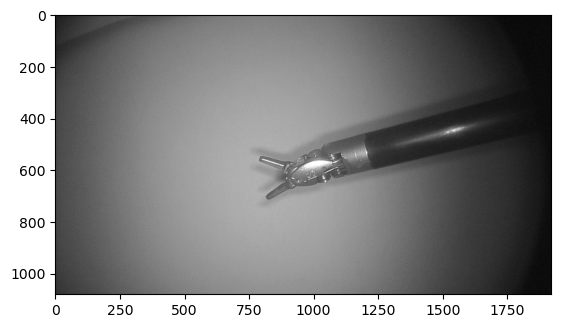

In [20]:
grey = cv2.cvtColor(rgb, cv2.COLOR_BGR2GRAY)
plt.imshow(grey, cmap = 'gray')

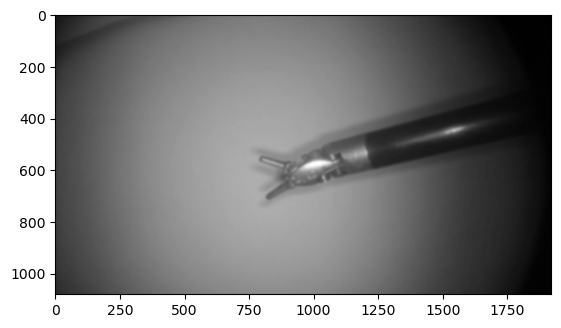

In [21]:
blur = cv2.GaussianBlur(grey, ksize=(25,25), sigmaX=0)
plt.imshow(blur, cmap = 'gray')

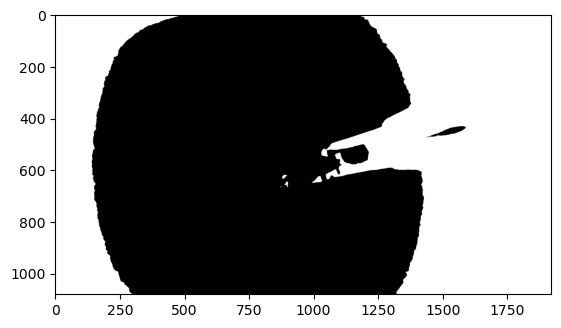

In [22]:

thresh, mask = cv2.threshold(blur, thresh = 150, maxval = 175, type = cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
plt.imshow(mask, cmap = 'gray')

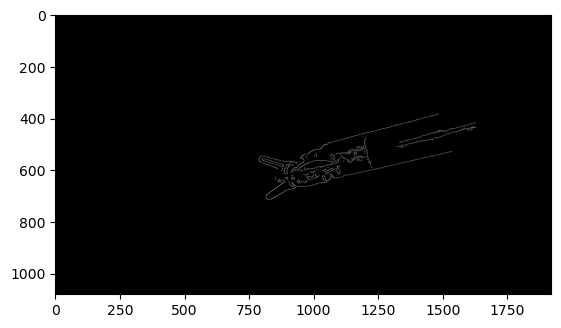

In [23]:
edges = cv2.Canny(blur, threshold1 = 200, threshold2 = 255, apertureSize = 5, L2gradient = True)
plt.imshow(edges, cmap = 'gray')


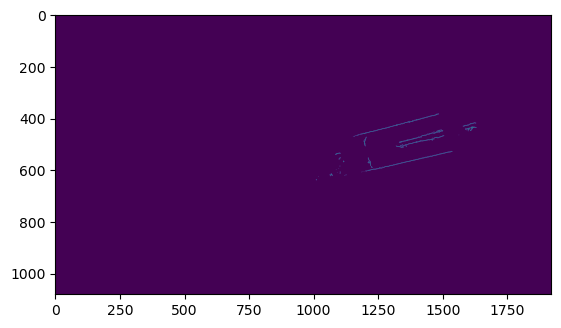

In [29]:
edges_and_mask = cv2.bitwise_and(edges, mask)
plt.imshow(edges_and_mask)


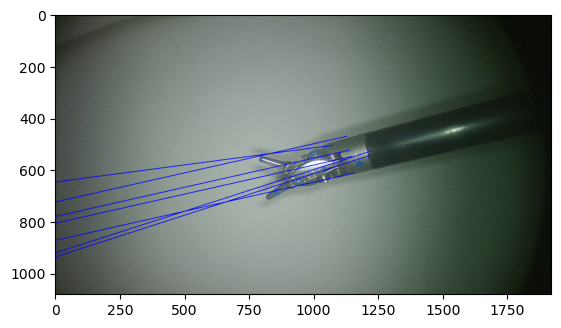

In [32]:

lines = cv2.HoughLinesWithAccumulator(edges_and_mask, rho = 5, theta = 0.09, threshold = 100) 
lines = np.squeeze(lines)
# sort by max votes
sorted_lines = lines[(-lines[:, 2]).argsort()]
for i in range(sorted_lines.shape[0]):
    rho = sorted_lines[i, 0]
    theta = sorted_lines[i, 1]
    a = math.cos(theta)
    b = math.sin(theta)
    x0 = a * rho
    y0 = b * rho
    pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
    pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
    cv2.line(rgb, pt1, pt2, (0,0,255), 2)
plt.imshow(rgb)


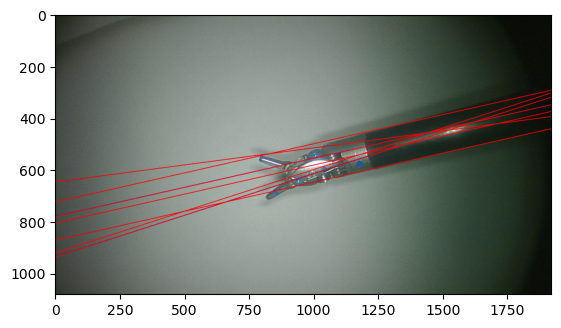

In [33]:

rho_clusters = fclusterdata(sorted_lines[:, 0].reshape(-1, 1), t = 5, criterion = 'distance', method = 'complete')
theta_clusters = fclusterdata(sorted_lines[:, 1].reshape(-1, 1), t = 0.09, criterion = 'distance', method = 'complete')

best_lines = []
checked_clusters = []
for i in range(sorted_lines.shape[0]):
    rho_cluster = rho_clusters[i]
    theta_cluster = theta_clusters[i]
    cluster = (rho_cluster, theta_cluster)
    if (cluster in checked_clusters):
        continue
    best_lines.append([lines[i, 0], lines[i, 1]])
    checked_clusters.append(cluster)

best_lines = np.asarray(best_lines)

for i in range(best_lines.shape[0]):
    rho = best_lines[i, 0]
    theta = best_lines[i, 1]
    a = math.cos(theta)
    b = math.sin(theta)
    x0 = a * rho
    y0 = b * rho
    pt1 = (int(x0 + 2000*(-b)), int(y0 + 2000*(a)))
    pt2 = (int(x0 - 2000*(-b)), int(y0 - 2000*(a)))
    cv2.line(rgb, pt1, pt2, (255,0,0), 2)
plt.imshow(rgb)